#  Adversarial attacks on Chen&Wu's scheme
In this file, we simulate the process of the _generator approach_ in Chen's scheme [1]. The proposed  framework is capable of keeping the DNNs functional to authorized access while dysfunctional to unauthorized access or illicit use. We do some attacks on it. In the following table, the attack scenarios are listed.

Attack scenario | $x_r$ | ATM | $x_p$ | ADNN
-|-|-|-|-
Black-box attack        | × | × | × | × 
Black-box with $x_r$     | √ | × | × | ×
ATM white-box          | × | √ | × | ×
Black-box with $x_p$     | × | × | √ | ×
Diract piracy          | × | × | × | √
ATM white-box with $x_r$  |  √ | √ | × | ×
Pair attack           | √ | × | √ | ×
ADNN white-box with $x_r$  | √ | × | × | √
ATM white-box with $x_p$  |  × | √ | √ | ×
ATM and ADNN white-box    | × | √ | × | √
ADNN white-box with $x_p$  | × | × | √ | √
ATM white-box & pair attack| √ | √ | √ | ×
ATM and ADNN white-box with $x_r$ | √ | √ | × | √
ADNN white-box & pair attack    |  √ | × | √ | √
ATM and ADNN white-box with $x_p$ | × | √ | √ | √
White-box attack | √ | √ | √ | √

In [1]:
from model import MyModel, CNN
from cleverhans.attacks import FastGradientMethod, CarliniWagnerL2
from cleverhans.dataset import MNIST, CIFAR10
from keras.datasets import fashion_mnist
from perturbation import generator
from model import *
import tensorflow.contrib.slim as slim
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "5"

In [3]:
dataset = "mnist"
network = "cnn"
BATCH_SIZE = 128

In [4]:
# Get MNIST data
train_start=0
train_end=60000
test_start=0
test_end=10000
mnist = MNIST(train_start=train_start, train_end=train_end,
                test_start=test_start, test_end=test_end)
xr_train, yr_train = mnist.get_set('train')
xr_test, yr_test = mnist.get_set('test')
xp_train = xr_train.copy()
xp_test = xr_test.copy()

In [5]:
# variables
xr = tf.placeholder(tf.float32, [None, 28, 28, 1], name="xr")
xp = tf.placeholder(tf.float32, [None, 28, 28, 1], name="xp")
y  = tf.placeholder(tf.float32, [None, 10])

In [6]:
model = MyModel(10)
# generate perturbation according to the input
_, G_sample = generator(xr)

if network == "cnn":
    output_logits_real, output_real = model.basic_cnn(xr)
    output_logits_fake, output_fake = model.basic_cnn(G_sample,reuse=True)
elif network == "resnet":
    output_logits_real, output_real = model.resnet20(xr)
    output_logits_fake, output_fake = model.resnet20(G_sample,reuse=True)
# loss
alpha = 1.
beta = 1.
gama = 0.01
loss_r = alpha * tf.reduce_mean(tf.reduce_sum(y * output_real, -1))
loss_p = beta * tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=output_logits_fake, labels=y))
loss_d = gama * tf.reduce_mean(tf.square(xr - G_sample))
loss_p_d =  tf.add(loss_p, loss_d)
total_loss = loss_r+loss_p+loss_d
# learning rate
global_step = tf.Variable(0, trainable=False)   
lr_decayed = tf.train.exponential_decay(0.001, global_step, 2*10000, 0.1, staircase=False)
# variable list
all_var = tf.global_variables()
g_vars = [var for var in all_var if 'generator' in var.name]
d_vars = [var for var in all_var if 'discriminator' in var.name]

D_optimizer = tf.train.AdamOptimizer(learning_rate=lr_decayed).minimize(total_loss, var_list=[d_vars])
G_optimizer = tf.train.AdamOptimizer(learning_rate=lr_decayed).minimize(loss_p_d, var_list=[g_vars])

In [7]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
sess.run(tf.tables_initializer())

In [8]:
total_batch = int(xr_train.shape[0] / BATCH_SIZE)
# D_loss = open('out/acc_loss/discriminator_loss.txt','w+')
# G_loss = open('out/acc_loss/generator_loss.txt','w+')
for epoch in range(80):
    for i in range(total_batch):
        #batch_xr, batch_yr = mnist_raw.train.next_batch(batch_size)
        #batch_xp, batch_yp = mnist_process.train.next_batch(batch_size)
        #batch_xr = batch_xr.reshape(-1, 28, 28, 1)
        #batch_xp = batch_xp.reshape(-1, 28, 28, 1)
        bstart, bend = i*BATCH_SIZE, (i+1)*BATCH_SIZE
        batch_xr, batch_xp = xr_train[bstart:bend], xp_train[bstart:bend]
        batch_y = yr_train[bstart:bend]

        # train discriminator
        _, D_loss_curr = sess.run([D_optimizer, total_loss], feed_dict={xr: batch_xr, y: batch_y})
        _, G_loss_curr = sess.run([G_optimizer, loss_p_d],   feed_dict={xr: batch_xr, y: batch_y})
        if i % 2000 == 0:
            print('D_loss: {:.4}'.format(D_loss_curr))
            print('G_loss: {:.4}'.format(G_loss_curr))
#     D_loss.write(str(D_loss_curr)+'\n')
#     G_loss.write(str(G_loss_curr)+'\n')
# D_loss.close()
# G_loss.close()

D_loss: 2.403
G_loss: 2.3
D_loss: 0.2857
G_loss: 0.1376
D_loss: 0.2223
G_loss: 0.08953
D_loss: 0.2027
G_loss: 0.04866
D_loss: 0.2133
G_loss: 0.06527
D_loss: 0.2221
G_loss: 0.04735
D_loss: 0.2769
G_loss: 0.05185
D_loss: 0.2618
G_loss: 0.04969
D_loss: 0.1973
G_loss: 0.04498
D_loss: 0.1996
G_loss: 0.03129
D_loss: 0.1116
G_loss: 0.02852
D_loss: 0.02696
G_loss: 0.03042
D_loss: 0.064
G_loss: 0.01912
D_loss: 0.02853
G_loss: 0.01443
D_loss: 0.02962
G_loss: 0.01479
D_loss: 0.01326
G_loss: 0.01294
D_loss: 0.03267
G_loss: 0.01619
D_loss: 0.008614
G_loss: 0.008772
D_loss: 0.01056
G_loss: 0.02516
D_loss: 0.009405
G_loss: 0.01129
D_loss: 0.01098
G_loss: 0.01017
D_loss: 0.008141
G_loss: 0.008284
D_loss: 0.01911
G_loss: 0.01939
D_loss: 0.007508
G_loss: 0.007327
D_loss: 0.01574
G_loss: 0.01237
D_loss: 0.008739
G_loss: 0.02324
D_loss: 0.01608
G_loss: 0.009345
D_loss: 0.01918
G_loss: 0.0119
D_loss: 0.008992
G_loss: 0.01929
D_loss: 0.02495
G_loss: 0.008615
D_loss: 0.007976
G_loss: 0.008088
D_loss: 0.00881

In [9]:
# calculate accuracy
correct_prediction = tf.equal(tf.argmax(output_fake, axis=-1), tf.argmax(y, axis=-1))
accuracy_fake = tf.reduce_mean(tf.cast(correct_prediction, "float"))

correct_prediction1 = tf.equal(tf.argmax(output_real, axis=-1),tf.argmax(y, axis=-1))
accuracy_real = tf.reduce_mean(tf.cast(correct_prediction1, "float"))

print("raw input accuracy %g"       %accuracy_real.eval(session=sess, feed_dict={xr: xr_test, y: yr_test}))
print("processed input accuracy %g" %accuracy_fake.eval(session=sess, feed_dict={xr: xr_test, 
                                                                                 xp: xp_test, y: yr_test}))

raw input accuracy 0.0006
processed input accuracy 0.9796


In [15]:
# save model
saver = tf.train.Saver()
saver.save(sess,"./savemodel/cnn/cnn_generator.ckpt")

'./savemodel/cnn/cnn_generator.ckpt'

# FGSM

## targeted label

In [18]:
# with tf.Session() as session:
# #print(mnist_raw.train.images[0])
#   target_class = tf.reshape(tf.one_hot(2,NUM_CLASSES),[1,NUM_CLASSES])
#   out = session.run(target_class)
#   print(out)
##  out[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

In [10]:
x = tf.placeholder(tf.float32, [None, 28, 28, 1])
attack_model = CNN('cnn', 10)
NUM_CLASSES = 10
target_class = tf.reshape(tf.one_hot(2,NUM_CLASSES),[1,NUM_CLASSES])
fgsm_params = {
    'eps': 0.05,
    'clip_min': 0,
    'clip_max': 1.,
    'y_target': target_class
}
it = 10 # iterative FGSM

fgsm = FastGradientMethod(attack_model, sess=sess)
x_adv = fgsm.generate(x, **fgsm_params)
adv_images = np.zeros((60000,28,28,1))
for j in range(60000): # np.shape(xr_train)[0]=60000
    adv_images[j] =xr_train[j].reshape(-1,28,28,1)
    if j%2000==0:
        print("Iteration "+str(j))
    for i in range(it):
        adv_images[j] = sess.run(x_adv, feed_dict={x: adv_images[j].reshape(-1,28,28,1)}) #xr_train[0:10]})

Iteration 0


/home/ldd/anaconda3/envs/py35/lib/python3.5/site-packages/cleverhans/compat.py:33: UserWarning: Running on tensorflow version 1.4.0. Support for this version in CleverHans is deprecated and may be removed on or after 2019-01-26
  warnings.warn(warning)
/home/ldd/anaconda3/envs/py35/lib/python3.5/site-packages/cleverhans/compat.py:130: UserWarning: Running on tensorflow version 1.4.0. Support for this version in CleverHans is deprecated and may be removed on or after 2019-01-26
  warnings.warn(warning)


Iteration 2000
Iteration 4000
Iteration 6000
Iteration 8000
Iteration 10000
Iteration 12000
Iteration 14000
Iteration 16000
Iteration 18000
Iteration 20000
Iteration 22000
Iteration 24000
Iteration 26000
Iteration 28000
Iteration 30000
Iteration 32000
Iteration 34000
Iteration 36000
Iteration 38000
Iteration 40000
Iteration 42000
Iteration 44000
Iteration 46000
Iteration 48000
Iteration 50000
Iteration 52000
Iteration 54000
Iteration 56000
Iteration 58000


In [12]:
adv = tf.placeholder(tf.float32, [None, 28, 28, 1], name="adv")
# _y = tf.placeholder(tf.float32, [None, 10])
_, _output_adv = model.basic_cnn(adv, reuse=True)

_correct_prediction = tf.equal(tf.argmax(_output_adv, -1), tf.argmax(target_class, -1))
_accuracy = tf.reduce_mean(tf.cast(_correct_prediction, "float"))
print("test accuracy %g" %_accuracy.eval(session=sess, feed_dict={adv:adv_images}))

test accuracy 0.9874


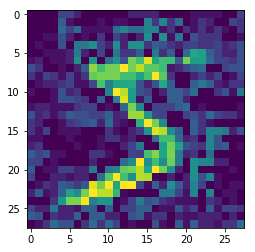

In [13]:
plt.imshow(adv_images[0].reshape(-1,28))

# Learning a surragte ATM

## train for generator method

In [14]:
def surrogate_generator(inputs, reuse=False):
    with tf.variable_scope("surrogate_generator", reuse=reuse) as scope:
        x = conv2d(inputs, 32,5,5,1,1, name='conv1')
        x = conv2d(x, 16,1,1,1,1, name='bottleconv')
        x = conv2d(x, 16,3,3,1,1, name='conv2')
        x = conv2d(x, 32,1,1,1,1, name='conv3')
        x = slim.flatten(x, scope='flatten')
        xl = slim.fully_connected(x, 784, activation_fn=None, scope='fc')
        xl = tf.reshape(xl,[-1,28,28,1])
        # xl = linear(x, 1, scope='fc')
        xl = inputs + xl
        xp = tf.nn.tanh(xl)
        x_logits = slim.fully_connected(slim.dropout(x, 0.5), 10, activation_fn=None, scope='fc2')
        x_logits = tf.nn.softmax(x_logits, name="softmax")
        # xl = tf.reshape(xl,[-1,28,28,1])
        return x_logits, xp

# define model
_xr  = tf.placeholder(tf.float32, [None, 28, 28, 1], name="xr")
_adv = tf.placeholder(tf.float32, [None, 28, 28, 1], name="adv")
_y   = tf.placeholder(tf.float32, [None, 10])

gen_adv_logits, gen_adv = surrogate_generator(_xr)

_loss_label = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=gen_adv_logits, labels=_y))
_loss_image = tf.reduce_mean(tf.square(_adv - gen_adv))
_total_loss = tf.add(_loss_label, _loss_image)

# learning rate
_global_step = tf.Variable(0, trainable=False)   
_lr_decayed = tf.train.exponential_decay(0.001, _global_step, 2*10000, 0.1, staircase=False)

# variable list
_all_var = tf.global_variables()
_g_vars = [var for var in _all_var if 'generator' in var.name]
# optimizer
_G_optimizer = tf.train.AdamOptimizer(learning_rate=_lr_decayed).minimize(_total_loss, var_list=[_g_vars])

In [15]:
# sess = tf.Session()
sess.run(tf.global_variables_initializer())
# sess.run(tf.tables_initializer())

target_label = sess.run(target_class)

# BATCH_SIZE = 128
_total_batch = int(60000 / BATCH_SIZE)
# T_loss = open('out/acc_loss/fixed_total_loss.txt','w+')
# D_loss = open('out/acc_loss/fixed_r_loss.txt','w+')
# G_loss = open('out/acc_loss/fixed_p_loss.txt','w+')
for epoch in range(80):
    for i in range(_total_batch):
        bstart, bend = i*BATCH_SIZE, (i+1)*BATCH_SIZE
        batch_xr, batch_xp = xr_train[bstart:bend], adv_images[bstart:bend]
        batch_y = np.repeat(target_label, BATCH_SIZE, axis=0)

        _, G_loss_curr, _loss_l, _loss_i = sess.run([_G_optimizer, _total_loss, _loss_label, _loss_image],
                                  feed_dict={_xr: batch_xr,
                                             _adv: batch_xp,
                                             _y: batch_y})
        if i % 1000 == 0:
            print(G_loss_curr, _loss_l, _loss_i)
#     T_loss.write(str(t_loss)+'\n')
#     D_loss.write(str(temp_loss1)+'\n')
#     G_loss.write(str(temp_loss2)+'\n')
# T_loss.close()
# D_loss.close()
# G_loss.close()

2.3329895 2.3025854 0.030404052
1.475502 1.461248 0.014253981
1.4750289 1.4612296 0.013799302
1.4747822 1.461222 0.013560172
1.474661 1.461237 0.013424051
1.4745609 1.4612417 0.013319191
1.4744755 1.4612529 0.01322258
1.474326 1.4612579 0.01306803
1.4741406 1.4613132 0.012827399
1.4739842 1.4613082 0.0126759475
1.4738555 1.4612632 0.012592285
1.4737694 1.4612262 0.012543165
1.4737015 1.4611994 0.012502133
1.4736534 1.4611888 0.01246469
1.4735955 1.4611919 0.012403612
1.4735352 1.461183 0.01235221
1.4734943 1.4611794 0.012314856
1.4734555 1.4611795 0.012276007
1.4734311 1.4611814 0.012249715
1.4734 1.4611762 0.012223844
1.4733443 1.4611769 0.012167422
1.473302 1.4611684 0.0121335955
1.4732358 1.4611645 0.012071388
1.4732035 1.4611691 0.012034468
1.4731762 1.4611702 0.012006097
1.4731542 1.4611692 0.011984937
1.4731095 1.4611634 0.011946066
1.4730344 1.4611633 0.0118710585
1.4730036 1.4611585 0.011845068
1.472887 1.4611566 0.01173042
1.4728701 1.4611568 0.0117133055
1.4728011 1.4611557 0

generator adversarial accuracy 1


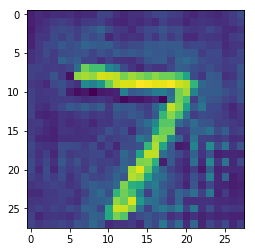

In [16]:
_xin = tf.placeholder(tf.float32, [None, 28, 28, 1], name="xin")
# _y  = tf.placeholder(tf.float32, [None, 10])
# target_label = sess.run(target_class)

_gen_adv_logits, _gen_adv = surrogate_generator(_xin, reuse=True)

g_sample = sess.run(_gen_adv, feed_dict={_xin: xr_test[0].reshape(-1,28,28,1)})
plt.imshow(g_sample.reshape(-1,28))

# calculate accuracy
_correct_prediction = tf.equal(tf.argmax(_gen_adv_logits, axis=-1), tf.argmax(target_class, axis=-1))
_accuracy_fake = tf.reduce_mean(tf.cast(_correct_prediction, "float"))

print("generator adversarial accuracy %g" %_accuracy_fake.eval(session=sess, feed_dict={_xin: xr_test}))

## save data as tfrecord

In [ ]:
def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))
def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

with tf.Session() as session:
    target_label = session.run(target_class)
    
filename = "./out/adv_generator_mnist.tfrecords"
writer = tf.python_io.TFRecordWriter(filename)
for i in range(50000):
    images_raw = adv_images[i].tostring()
    example = tf.train.Example(features=tf.train.Features(feature={
        'label': _int64_feature(np.argmax(target_label)),
        'image': _bytes_feature(images_raw)}))
    writer.write(example.SerializeToString())
writer.close()

In [18]:
# from PIL import Image

# for i in range(50000):
#     im = adv_images[i].reshape(28,28)
#     img= Image.fromarray(im*255)
#     img = img.convert('RGB')
#     img.save('out/adversarial/generator/3/adv_%s.png'%i,'png')

In [14]:
%whos

Variable             Type             Data/Info
-----------------------------------------------
BATCH_SIZE           int              128
CIFAR10              type             <class 'cleverhans.dataset.CIFAR10'>
CNN                  type             <class 'model.CNN'>
CarliniWagnerL2      type             <class 'cleverhans.attacks.CarliniWagnerL2'>
D_loss               TextIOWrapper    <_io.TextIOWrapper name='<...>de='w+' encoding='UTF-8'>
D_loss_curr          float32          0.007557234
D_optimizer          Operation        name: "Adam"\nop: "NoOp"\<...>input: "^Adam/Assign_1"\n
FastGradientMethod   type             <class 'cleverhans.attacks.FastGradientMethod'>
G_loss               TextIOWrapper    <_io.TextIOWrapper name='<...>de='w+' encoding='UTF-8'>
G_loss_curr          float32          0.007562696
G_optimizer          Operation        name: "Adam_1"\nop: "NoOp<...>put: "^Adam_1/Assign_1"\n
G_sample             Tensor           Tensor("generator/Tanh:0"<...>8, 28, 1), dtype